NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 171 290 107 46 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 37 80 23 14 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 164 302 95 53 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 34 81 22 17 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 159 308 89 58 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 34 83 20 17 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 159 312 85 58 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 34 84 19 17 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 158 315 82 59 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 33 85 18 18 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 157 318 79 60 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 32 86 17 19 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 157 319 78 60 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 31 86 17 20 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 156 319 78 61 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 31 86

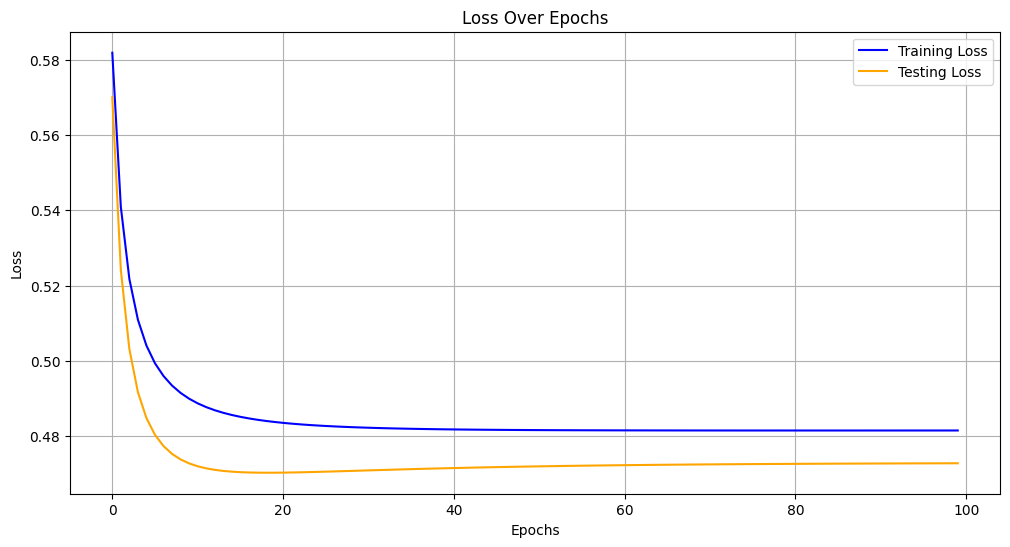

accuracy_test= 0.7532467532467533
precision_test= 0.6444444444444445
recall_test= 0.5686274509803921
f1score_test= 0.6041666666666666


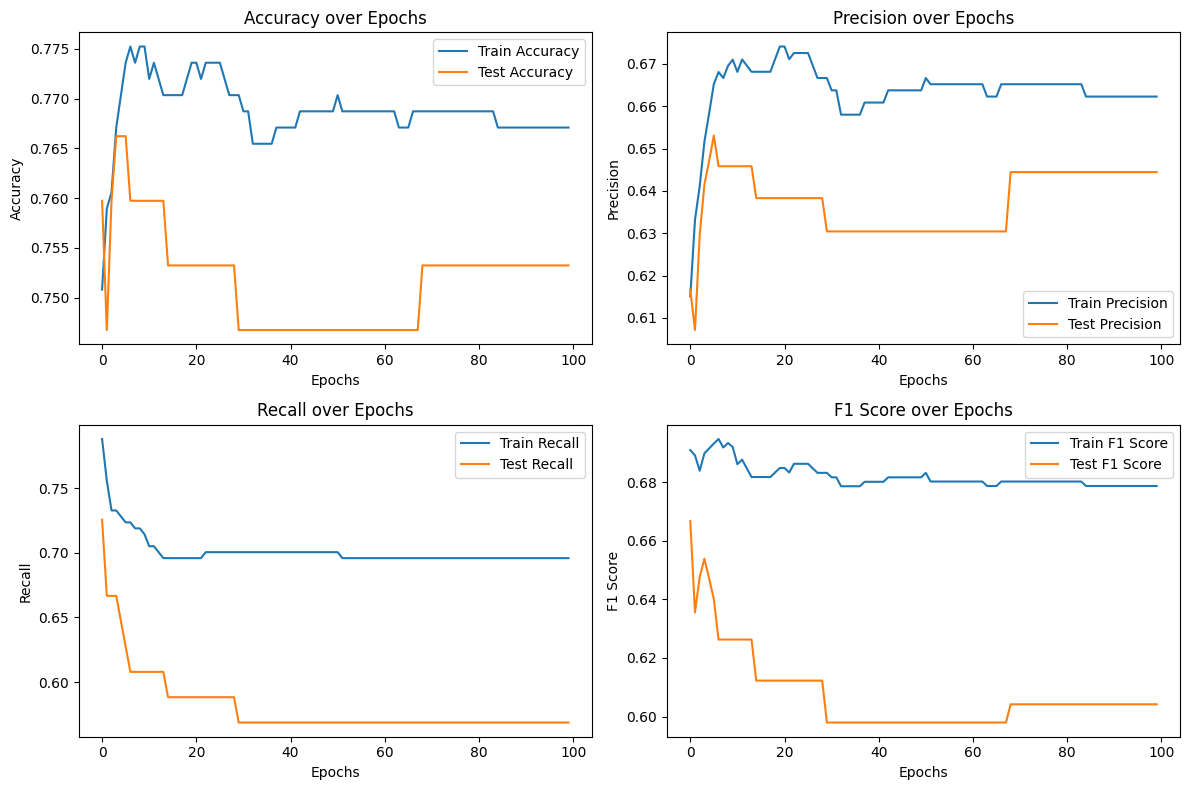

AUC: 0.8369568246716163


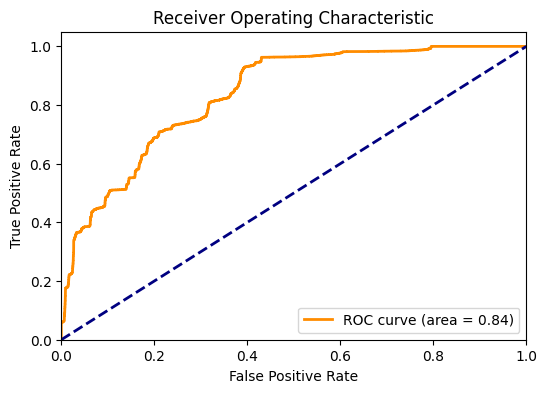

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

# Load data from CSV
data = pd.read_csv("/content/sample_data/diabetes.csv")


# Extract the necessary columns
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data_m = data[columns].to_numpy()

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid for backpropagation
def sigmoid_derivative(x):
    return x * (1 - x)

# Binary cross-entropy loss function
def binary_cross_entropy(y_true, y_pred):
    # Clip y_pred to avoid log(0) which is undefined
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Process data with median and normalization
def process_data_median(col):
    non_zero_values = data_m[data_m[:, col] != 0, col]
    median_value = np.median(non_zero_values)
    data_m[data_m[:, col] == 0, col] = median_value

def normalise(col):
    norm_col1 = data_m[:, col]
    min_v, max_v = np.min(norm_col1), np.max(norm_col1)
    data_m[:, col] = (norm_col1 - min_v) / (max_v - min_v)

# Applying processing and normalization based on the column flags
for i in range(8):
    process_data_median(i)
    normalise(i)

nb_param = 10

# Use train_test_split to split the data into training and testing sets
X_train, X_test = train_test_split(data_m, test_size=0.2)

# Set the training and testing rows
rows_tr = X_train.shape[0]

# Initialize theta for the perceptron
theta = np.array([0.5] * (nb_param - 1) + [1.0])

# Lists to store metrics for plotting for the perceptron
accuracy_train, precision_train, recall_train, f1score_train = [], [], [], []
accuracy_test, precision_test, recall_test, f1score_test = [], [], [], []
y_true_test, y_scores_test = [], []
loss_train, loss_test = [], []  # Lists to store the loss values

# Perceptron training function
def perceptron(lr, nbp, epochs, theta):
    for epoch in range(epochs):
        for i in range(rows_tr):
            Prod = np.prod(X_train[i, :-1].astype(np.float64))
            output_layer = sigmoid(np.dot(X_train[i, :-1].astype(np.float64), theta[:-2]) +  Prod*theta[-2] +theta[-1])

            # Calculate the error
            error = X_train[i, 8] - output_layer  # X_train[i, 8] is the ground truth
            d_output = error * sigmoid_derivative(output_layer)

            # Update thetas
            theta[:-2] += lr * d_output * X_train[i, :-1].astype(np.float64)
            theta[-2] += lr * d_output * Prod
            theta[-1] += lr * d_output

        # Evaluate and store metrics after each epoch
        train_metrics = evaluate(0, rows_tr, X_train, theta)
        accuracy_train.append(train_metrics[0])
        precision_train.append(train_metrics[1])
        recall_train.append(train_metrics[2])
        f1score_train.append(train_metrics[3])

        test_metrics = evaluate(0, X_test.shape[0], X_test, theta)
        accuracy_test.append(test_metrics[0])
        precision_test.append(test_metrics[1])
        recall_test.append(test_metrics[2])
        f1score_test.append(test_metrics[3])

        # Store true labels and predicted scores for the ROC curve
        y_true_test.extend(X_test[:, 8])
        y_scores_test.extend(calculate_scores(0, X_test.shape[0], X_test, theta))


        # Compute and store the loss for both training and testing sets
        loss_train.append(binary_cross_entropy(X_train[:, 8], calculate_scores(0, rows_tr, X_train, theta)))
        loss_test.append(binary_cross_entropy(X_test[:, 8], calculate_scores(0, X_test.shape[0], X_test, theta)))

# Evaluation function
def evaluate(start_idx, end_idx, data, theta1):
    Prod = np.prod(data[start_idx:end_idx, :-1], axis=1) # Product of all xi , i=2..7
    y_hat = sigmoid(np.dot(data[start_idx:end_idx, :-1], theta[:-2].T) + theta[-2] * Prod + theta[-1])
    y_hat = np.where(y_hat >= 0.5, 1.0, 0.0)
    # Use column 8 for diagnosis
    NbTruePos = np.sum((data[start_idx:end_idx, 8] == 1) & (y_hat == 1))
    NbTrueNeg = np.sum((data[start_idx:end_idx, 8] == 0) & (y_hat == 0))
    NbFalsePos = np.sum((data[start_idx:end_idx, 8] == 0) & (y_hat == 1))
    NbFalseNeg = np.sum((data[start_idx:end_idx, 8] == 1) & (y_hat == 0))
    print("NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg", NbTruePos , NbTrueNeg , NbFalsePos , NbFalseNeg, "\n")
    accuracy = (NbTruePos + NbTrueNeg) / (NbTruePos + NbTrueNeg + NbFalseNeg + NbFalsePos)
    precision = NbTruePos / (NbTruePos + NbFalsePos) if (NbTruePos + NbFalsePos) > 0 else 0
    recall = NbTruePos / (NbTruePos + NbFalseNeg) if (NbTruePos + NbFalseNeg) > 0 else 0
    F1Score = 2.0 * NbTruePos / (2.0 * NbTruePos + NbFalseNeg + NbFalsePos) if (2.0 * NbTruePos + NbFalseNeg + NbFalsePos) > 0 else 0
    #print("accuracy, precision, recall, F1Score=",accuracy, precision, recall, F1Score,"\n")
    return accuracy, precision, recall, F1Score

def calculate_scores(start_idx, end_idx, data, theta):
    Prod = np.prod(data[start_idx:end_idx, :-1], axis=1)  # Exclude the last columns for the product
    #y_scores1 = np.dot(data[start_idx:end_idx, :-1], theta[:-1].T) + theta[-1]  #
    y_scores = np.dot(data[start_idx:end_idx, :-1], theta[:-2].T) + Prod*theta[-2]+ theta[-1]  # Exclude the last columns for the dot product
    y_scores = sigmoid(y_scores)
    return y_scores

###################################################
# Run the perceptron
# Values of learning rate may be between 0.1 to 1.0, all these values give similar results
# values out of this inteval give also good results: 0.05, 0.01, or 1.2, 1.3 etc
# Around 60 epochs, there is a convergence of the system.
##################################################
perceptron(0.5, nb_param, 100, theta)




# Plot the loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(loss_train, label='Training Loss', color='blue')
plt.plot(loss_test, label='Testing Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
###################################################


# Plotting the metrics
plt.figure(figsize=(12, 8))

# Plot for accuracy
plt.subplot(2, 2, 1)
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_test, label='Test Accuracy')
print("accuracy_test=", accuracy_test[len(accuracy_test) - 1])
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for precision
plt.subplot(2, 2, 2)
plt.plot(precision_train, label='Train Precision')
plt.plot(precision_test, label='Test Precision')
print("precision_test=", precision_test[len(precision_test) - 1])
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot for recall
plt.subplot(2, 2, 3)
plt.plot(recall_train, label='Train Recall')
plt.plot(recall_test, label='Test Recall')
print("recall_test=", recall_test[len(recall_test) - 1])
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plot for F1 score
plt.subplot(2, 2, 4)
plt.plot(f1score_train, label='Train F1 Score')
plt.plot(f1score_test, label='Test F1 Score')
print("f1score_test=", f1score_test[len(f1score_test) - 1])
plt.title('F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_test, y_scores_test)
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(y_true_test, y_scores_test)
print('AUC: ' + str(auc_score))

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

